In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from nltk.tokenize import word_tokenize


# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

loading Pre-trained Model and Tokenizer:
# Here, you load a pre-trained model and tokenizer from the Hugging Face Transformers library. The model chosen is XLM-RoBERTa, a robust multi-lingual model, suitable for text classification tasks.
Text Preprocessing:


In [4]:
# Load pre-trained model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove words with length less than 3
    tokens = [word for word in tokens if len(word) > 2]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Load data
filepath = '/content/sample_data/Reddit_Roberta2_results (1).csv'
with open(filepath, 'r', encoding='utf-8') as f:
    text_data = f.readlines()

# Preprocess text data
text_data = [preprocess_text(text) for text in text_data]


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# This part defines a function preprocess_text for preprocessing raw text data. The preprocessing steps include converting text to lowercase, removing URLs and punctuation, tokenizing text, removing stopwords, lemmatizing tokens, and joining tokens back into a single string.**bold tex

In [ ]:

def detect_offensive_text(text_data):
    offensive_flags = []
    chunk_size = 512  # Maximum sequence length supported by the model
    for text_chunk in [text_data[i:i+chunk_size] for i in range(0, len(text_data), chunk_size)]:
        inputs = tokenizer(text_chunk, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        offensive_flags.extend(predictions.tolist())
    return offensive_flags

    # Map predictions to labels (e.g., 0 -> "Not Offensive", 1 -> "Offensive")
    label_map = {0: "Not Offensive", 1: "Offensive"}  # Define your label mapping
    offensive_flags = [label_map[pred.item()] for pred in predictions]

    return offensive_flags

offensive_flags = detect_offensive_text(text_data)

# Display or store results
for text, flag in zip(text_data, offensive_flags):
    print(f"Text: {text.strip()} -> Offensive: {flag}")


## defining a function detect_offensive_text to predict whether text is offensive or not using the pre-trained XLM-RoBERTa model. This function splits the input text into chunks, tokenizes them, passes them through the model, and predicts the offensive label for each chunk.**

In [ ]:
# Load your custom text file
custom_filepath = '/content/hindi_conversations.txt'
with open(custom_filepath, 'r', encoding='utf-8') as f:
    custom_text_data = f.readlines()

# Preprocess the custom text data
custom_text_data = [preprocess_text(text) for text in custom_text_data]

# Detect offensive text in the custom text data
custom_offensive_flags = detect_offensive_text(custom_text_data)

# Display or store results
for text, flag in zip(custom_text_data, custom_offensive_flags):
    print(f"Text: {text.strip()} -> Offensive: {flag}")


In [ ]:
# Specify the file path to save the results
results_filepath = 'results.txt'

# Open the file in write mode
with open(results_filepath, 'w', encoding='utf-8') as file:
    # Write the results to the file
    for text, flag in zip(custom_text_data, custom_offensive_flags):
        file.write(f"Text: {text.strip()} -> Offensive: {flag}\n")

print(f"Results saved to {results_filepath}")


In [4]:

# Define your custom model architecture
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])  # Use the last output of LSTM
        return output

from sklearn.preprocessing import LabelEncoder

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(data['label'])  # Encode labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['comment'])  # Ensure text type
        label = self.labels[idx]  # Get encoded label
        tokenized_text = word_tokenize(text.lower())
        encoded_text = self.tokenizer.convert_tokens_to_ids(tokenized_text)[:self.max_length]
        padding_length = self.max_length - len(encoded_text)
        encoded_text += [0] * padding_length  # Padding
        return torch.tensor(encoded_text), torch.tensor(label)


# Load and preprocess your dataset
dataset = pd.read_csv('/content/sample_data/Reddit_Roberta2_results (1).csv')
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
max_length = 128
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = CustomDataset(train_data, tokenizer, max_length)
test_dataset = CustomDataset(test_data, tokenizer, max_length)

# Define model parameters
input_size = tokenizer.vocab_size
hidden_size = 128
num_classes = 2

# Instantiate your custom model
model = CustomModel(input_size, hidden_size, num_classes)

# Define training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train your custom model
for epoch in range(num_epochs):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate your custom model
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size)
predictions = []
true_labels = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Test Accuracy: 0.6912275622466705


In [4]:

# Define your custom model architecture
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        output = self.fc(lstm_out[:, -1, :])  # Use the last output of LSTM
        return output

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(data['label'])  # Encode labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['comment'])  # Ensure text type
        label = self.labels[idx]  # Get encoded label
        tokenized_text = word_tokenize(text.lower())
        encoded_text = self.tokenizer.convert_tokens_to_ids(tokenized_text)[:self.max_length]
        padding_length = self.max_length - len(encoded_text)
        encoded_text += [0] * padding_length  # Padding
        return torch.tensor(encoded_text), torch.tensor(label)

# Load and preprocess your dataset
dataset = pd.read_csv('/content/sample_data/Reddit_Roberta2_results (1).csv')
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
max_length = 128
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = CustomDataset(train_data, tokenizer, max_length)
test_dataset = CustomDataset(test_data, tokenizer, max_length)

# Define model parameters
input_size = tokenizer.vocab_size
hidden_size = 128
num_classes = 2

# Instantiate your custom model
model = CustomModel(input_size, hidden_size, num_classes)

# Define training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Implement early stopping
patience = 3  # Number of epochs to wait if no improvement is observed
last_best_epoch = 0  # Initialize variable to track the epoch when the best accuracy was achieved
best_accuracy = 0  # Initialize variable to track the best accuracy

# Train your custom model with learning rate scheduling and early stopping
for epoch in range(num_epochs):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate your custom model on the test set
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    predictions = []
    true_labels = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy}")

    # Save the model if it achieves the best accuracy
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model.pth')
        best_accuracy = accuracy
        last_best_epoch = epoch  # Update last_best_epoch

    # Implement early stopping if the accuracy does not improve for a certain number of epochs
    if epoch - last_best_epoch >= patience:
        print("Early stopping...")
        break

# Load the best model for inference
best_model = CustomModel(input_size, hidden_size, num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()



Epoch 1/10, Test Accuracy: 0.6235524030110018
Epoch 2/10, Test Accuracy: 0.6768239722061378
Epoch 3/10, Test Accuracy: 0.686667631731326
Epoch 4/10, Test Accuracy: 0.7011436016213086
Epoch 5/10, Test Accuracy: 0.702518818760857
Epoch 6/10, Test Accuracy: 0.694195136074117
Epoch 7/10, Test Accuracy: 0.6960046323103648
Epoch 8/10, Test Accuracy: 0.6952808338158657
Early stopping...


CustomModel(
  (embedding): Embedding(250002, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1/10, Test Accuracy: 0.6234800231615518
Epoch 2/10, Test Accuracy: 0.6454834973943254
Epoch 3/10, Test Accuracy: 0.6975969889982628
Epoch 4/10, Test Accuracy: 0.6810220034742328
Epoch 5/10, Test Accuracy: 0.7013607411696584
Epoch 6/10, Test Accuracy: 0.7025911986103069
Epoch 7/10, Test Accuracy: 0.6994788650839606
Epoch 8/10, Test Accuracy: 0.7000579038795599
Epoch 9/10, Test Accuracy: 0.6947741748697163
Early stopping...


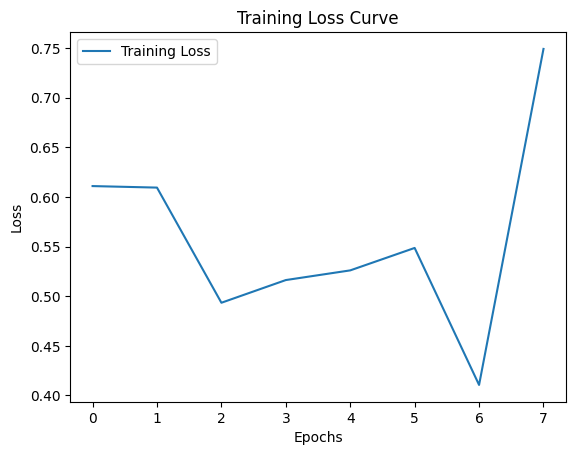

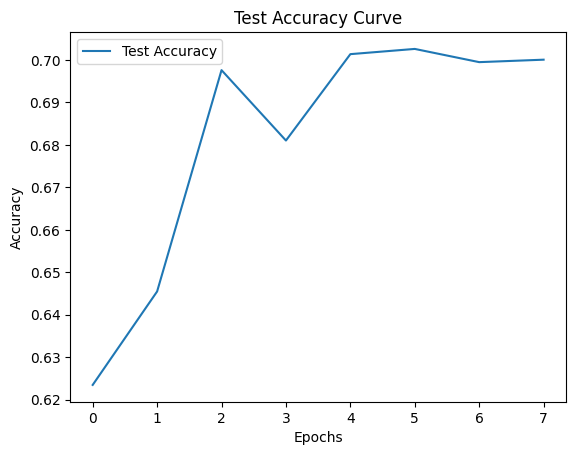

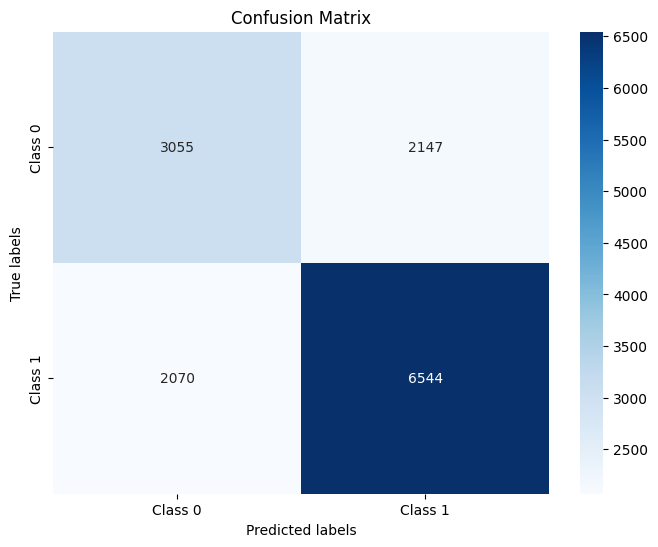

In [7]:

# Define your custom model architecture
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        output = self.fc(lstm_out[:, -1, :])  # Use the last output of LSTM
        return output

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(data['label'])  # Encode labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['comment'])  # Ensure text type
        label = self.labels[idx]  # Get encoded label
        tokenized_text = word_tokenize(text.lower())
        encoded_text = self.tokenizer.convert_tokens_to_ids(tokenized_text)[:self.max_length]
        padding_length = self.max_length - len(encoded_text)
        encoded_text += [0] * padding_length  # Padding
        return torch.tensor(encoded_text), torch.tensor(label)

# Load and preprocess your dataset
dataset = pd.read_csv('/content/sample_data/Reddit_Roberta2_results (1).csv')
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
max_length = 128
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = CustomDataset(train_data, tokenizer, max_length)
test_dataset = CustomDataset(test_data, tokenizer, max_length)

# Define model parameters
input_size = tokenizer.vocab_size
hidden_size = 128
num_classes = 2

# Instantiate your custom model
model = CustomModel(input_size, hidden_size, num_classes)

# Define training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training loss and test accuracy for plotting
train_loss_history = []
test_accuracy_history = []

# Implement early stopping
patience = 3  # Number of epochs to wait if no improvement is observed
last_best_epoch = 0  # Initialize variable to track the epoch when the best accuracy was achieved
best_accuracy = 0  # Initialize variable to track the best accuracy

# Train your custom model with learning rate scheduling and early stopping
for epoch in range(num_epochs):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate your custom model on the test set
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    predictions = []
    true_labels = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy}")

    # Save the model if it achieves the best accuracy
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model.pth')
        best_accuracy = accuracy
        last_best_epoch = epoch  # Update last_best_epoch

    # Implement early stopping if the accuracy does not improve for a certain number of epochs
    if epoch - last_best_epoch >= patience:
        print("Early stopping...")
        break

    # Save training loss and test accuracy for plotting
    train_loss_history.append(loss.item())
    test_accuracy_history.append(accuracy)

# Load the best model for inference
best_model = CustomModel(input_size, hidden_size, num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Plot Training Loss Curve
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/10, Train Loss: 0.6593, Val Loss: 0.6532
Epoch 2/10, Train Loss: 0.5987, Val Loss: 0.5780
Epoch 3/10, Train Loss: 0.5599, Val Loss: 0.5671
Epoch 4/10, Train Loss: 0.5359, Val Loss: 0.5620
Epoch 5/10, Train Loss: 0.5118, Val Loss: 0.5677
Epoch 6/10, Train Loss: 0.4837, Val Loss: 0.5851
Epoch 7/10, Train Loss: 0.4499, Val Loss: 0.5970
Epoch 8/10, Train Loss: 0.4102, Val Loss: 0.6418
Epoch 9/10, Train Loss: 0.3699, Val Loss: 0.6759
Epoch 10/10, Train Loss: 0.3283, Val Loss: 0.7430
Test Accuracy: 0.7047, Precision: 0.7398, Recall: 0.8118, F1-score: 0.7742, ROC AUC: 0.6696


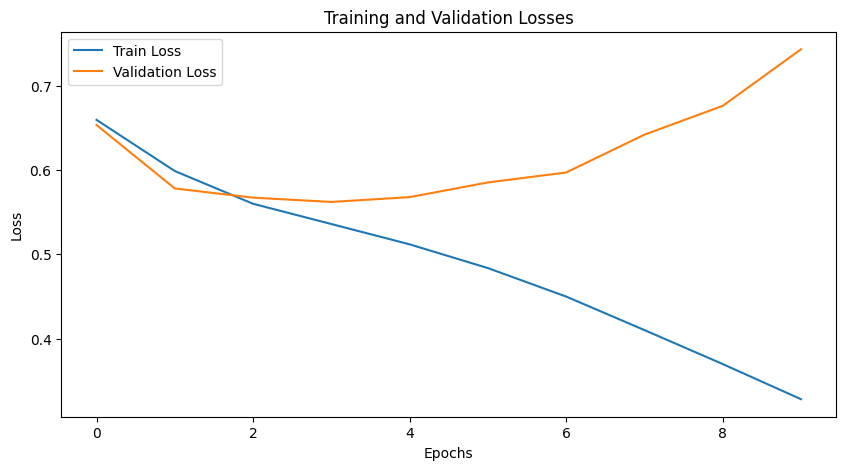

In [8]:

# Define your custom model architecture
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])  # Use the last output of LSTM
        return output

from sklearn.preprocessing import LabelEncoder

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(data['label'])  # Encode labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['comment'])  # Ensure text type
        label = self.labels[idx]  # Get encoded label
        tokenized_text = word_tokenize(text.lower())
        encoded_text = self.tokenizer.convert_tokens_to_ids(tokenized_text)[:self.max_length]
        padding_length = self.max_length - len(encoded_text)
        encoded_text += [0] * padding_length  # Padding
        return torch.tensor(encoded_text), torch.tensor(label)


# Load and preprocess your dataset
dataset = pd.read_csv('/content/sample_data/Reddit_Roberta2_results (1).csv')
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
max_length = 128
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = CustomDataset(train_data, tokenizer, max_length)
test_dataset = CustomDataset(test_data, tokenizer, max_length)

# Define model parameters
input_size = tokenizer.vocab_size
hidden_size = 128
num_classes = 2

# Instantiate your custom model
model = CustomModel(input_size, hidden_size, num_classes)

# Define training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train your custom model
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validate the model
    model.eval()
    val_loader = DataLoader(test_dataset, batch_size=batch_size)
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    # Save the model with the best validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate your custom model
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size)
predictions = []
true_labels = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()
